In [1]:
from ga_regression import *
from matplotlib import pyplot as plt
from functools import partial
import PIL
import matplotlib as mpl
from matplotlib.cm import ScalarMappable
from pvutils import iter_subplots
from pyvista import PolyData
import pyvista as pv
from scipy.stats import pearsonr
from ga_population import *
import warnings
from matplotlib.colors import ListedColormap
import potpourri3d as pp3d
from itertools import cycle

C:\Users\dg\.conda\envs\diffnet4\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\dg\Documents\python\diffusion-net\experiments\regression_0\ga_regression.py:23: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
paths = {
    51: Path(r"D:\resynth\run_51_52\run00051_resynth\2025-09-16-15-34-44\opts_and_metadata.pt"),
    42: Path(r"D:\resynth\run_42_43\run00042_resynth\2025-09-11-16-14-13\opts_and_metadata.pt"),
    48: Path(r"D:\resynth\run_48_49\run00048_resynth\2025-09-12-13-05-14\opts_and_metadata.pt"),
    38: Path(r"D:\resynth\run_38_39\run00038_resynth\2025-09-13-10-59-36\opts_and_metadata.pt"),
    20: Path(r"D:\resynth\run_20_21\run00020_resynth\2025-09-14-15-06-07\opts_and_metadata.pt"),
     9: Path(r"D:\resynth\run_09_10\run00009_resynth\2025-09-15-10-17-13\opts_and_metadata.pt"),
}
readers = {run_id: Readers.from_file(f) for run_id, f in paths.items()}

In [3]:
def get_readers(visible_mode: UseVisibleMode | None):
    out = dict()
    tgt = str(visible_mode)
    for run_id, rs in readers.items():
        idx = next(i for i, v in rs.hparams.use_visible.items() if str(v) == tgt)
        out[run_id] = rs[idx]
    return out

# rs = get_readers(UseVisibleMode(False, False))

def get_src_models(visible_mode: UseVisibleMode | None):
    readers = get_readers(visible_mode)
    return {
        run_id: SourceModel.from_reader(reader, cp_data_file=Path(SourceModels.cp_data_files(run_id)))
        for run_id, reader in readers.items()
    }

# _sms = get_src_models(UseVisibleMode(False, False))
_sms = get_src_models(None)
sms = SourceModels(list(_sms.values()))

In [4]:
pms = [p.cached() for p in ProbeMeshSpec.defined()]

In [5]:
recache = False
cp_pm_preds = sms.corpus_probe_mesh_preds(pms=pms, cache_file='cp_pm_preds.hdf', recache=recache)
cp_responses = sms.corpus_observed_responses(cp_pm_preds=cp_pm_preds, cache_file='cpm_responses.hdf', recache=recache)

In [6]:
# vertex weights is a n_stim list of VertexWeights, wehere VertexWeights.weights is (n_vertices, n_channels_total)
# cp_vertex_weights = sms.get_weights(pms, expt_kwargs=dict(outputs_at='vertices'))
# torch.save(cp_vertex_weights, 'cp_vertex_weights.pt')
cp_vertex_weights = torch.load('cp_vertex_weights.pt')

In [7]:
def norm_weights(vertex_weights: VertexWeights, percentiles: list[float]):
    vws = vertex_weights.weights
    min_vw, max_vw = vws.min(axis=0), vws.max(axis=0)
    norm_vw = (vws - min_vw) / (max_vw - min_vw)
    thresh = np.percentile(norm_vw, percentiles, axis=0)
    return norm_vw, thresh

pm_idx = 0
pm = pms[pm_idx]
percentiles = [90, 95, 98, 99]
n_percentiles = len(percentiles)

norm_vws, norm_vw_thresholds = norm_weights(cp_vertex_weights[pm_idx], percentiles)
norm_vw_thresholds.shape

(5, 86)

In [8]:
class ProbeMeshPlotter:
    def __init__(
        self, 
        pm: ProbeMesh, 
        window_size=(512, 512),
    ):
        self.pm = pm
        p = self.plotter = pv.Plotter(window_size=window_size, off_screen=True)
        p.camera = pm.camera
        p.add_mesh(pm.mesh, color='gray')

    def add_contour(self, scalars, thresh, color, line_width=5):
        contour = self.pm.mesh.contour(isosurfaces=thresh, scalars=scalars)
        self.plotter.add_mesh(contour, line_width=line_width, color=color)

    def add_contours(self, weights, thresholds, colors, line_width=5):
        for scalars, thresh, color in zip(weights.T, thresholds, colors):
            self.add_contour(scalars, thresh, color, line_width=line_width)
            
    def finish(self):
        img = self.plotter.screenshot()
        self.plotter.close()
        return PIL.Image.fromarray(img)
        

In [23]:
30 / 4

7.5

In [33]:
fig.savefig

<bound method Figure.savefig of <Figure size 2400x3600 with 24 Axes>>

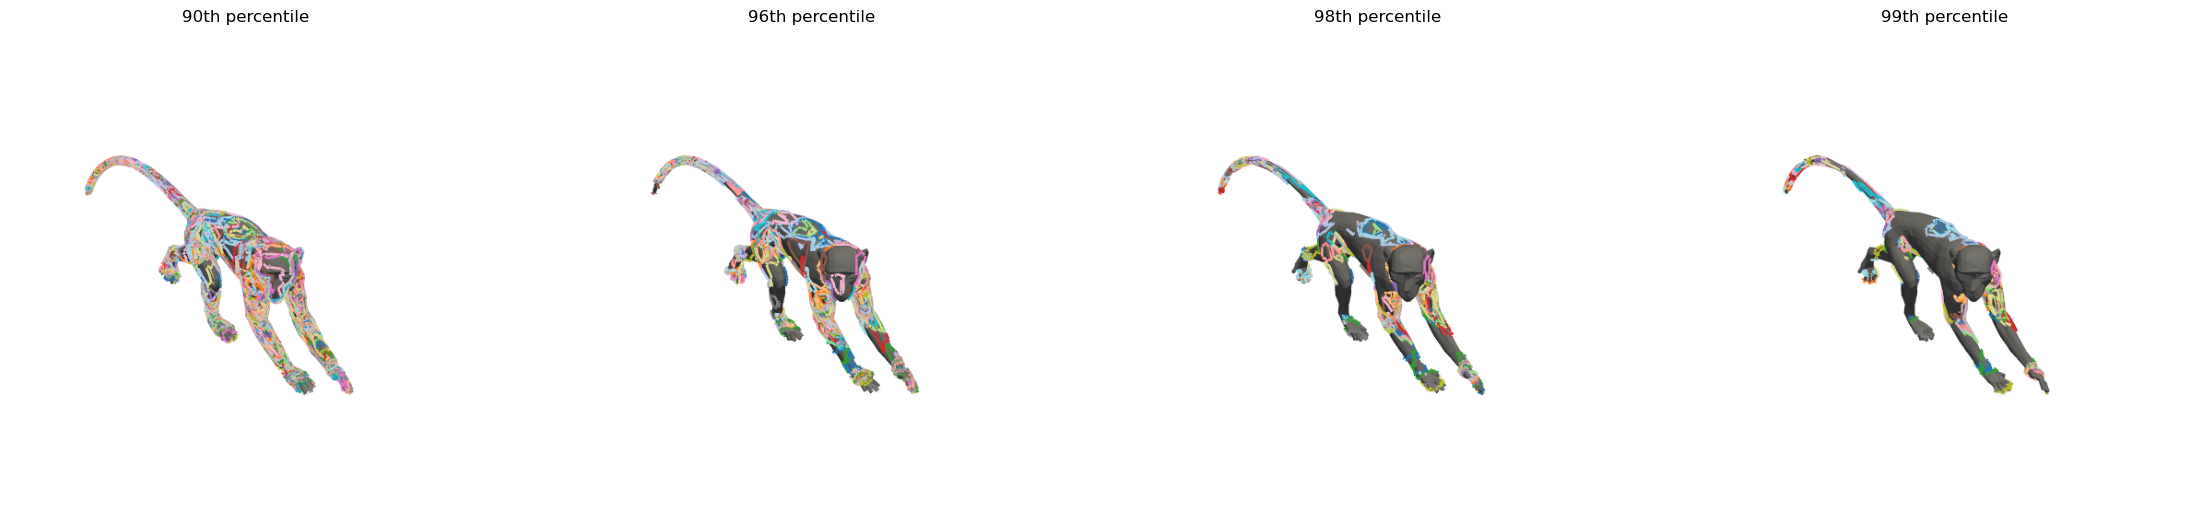

In [34]:
pm_idx = 0
pm = pms[pm_idx]
percentiles = [90, 96, 98, 99]
n_percentiles = len(percentiles)

norm_vws, norm_vw_thresholds = norm_weights(cp_vertex_weights[pm_idx], percentiles)

img_sz = 7
fig, axs = plt.subplots(1, n_percentiles, figsize=(img_sz * n_percentiles, img_sz))

for ax, pct, thresholds in zip(axs, percentiles, norm_vw_thresholds):
    pmp = ProbeMeshPlotter(pm=pm)
    pmp.add_contours(weights=norm_vws, thresholds=thresholds, colors=cycle(mpl.colormaps['tab20'].colors))
    img = pmp.finish()

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'{pct}th percentile')

# fig.savefig('exported_channels/monkey_weight_isocontours.png')

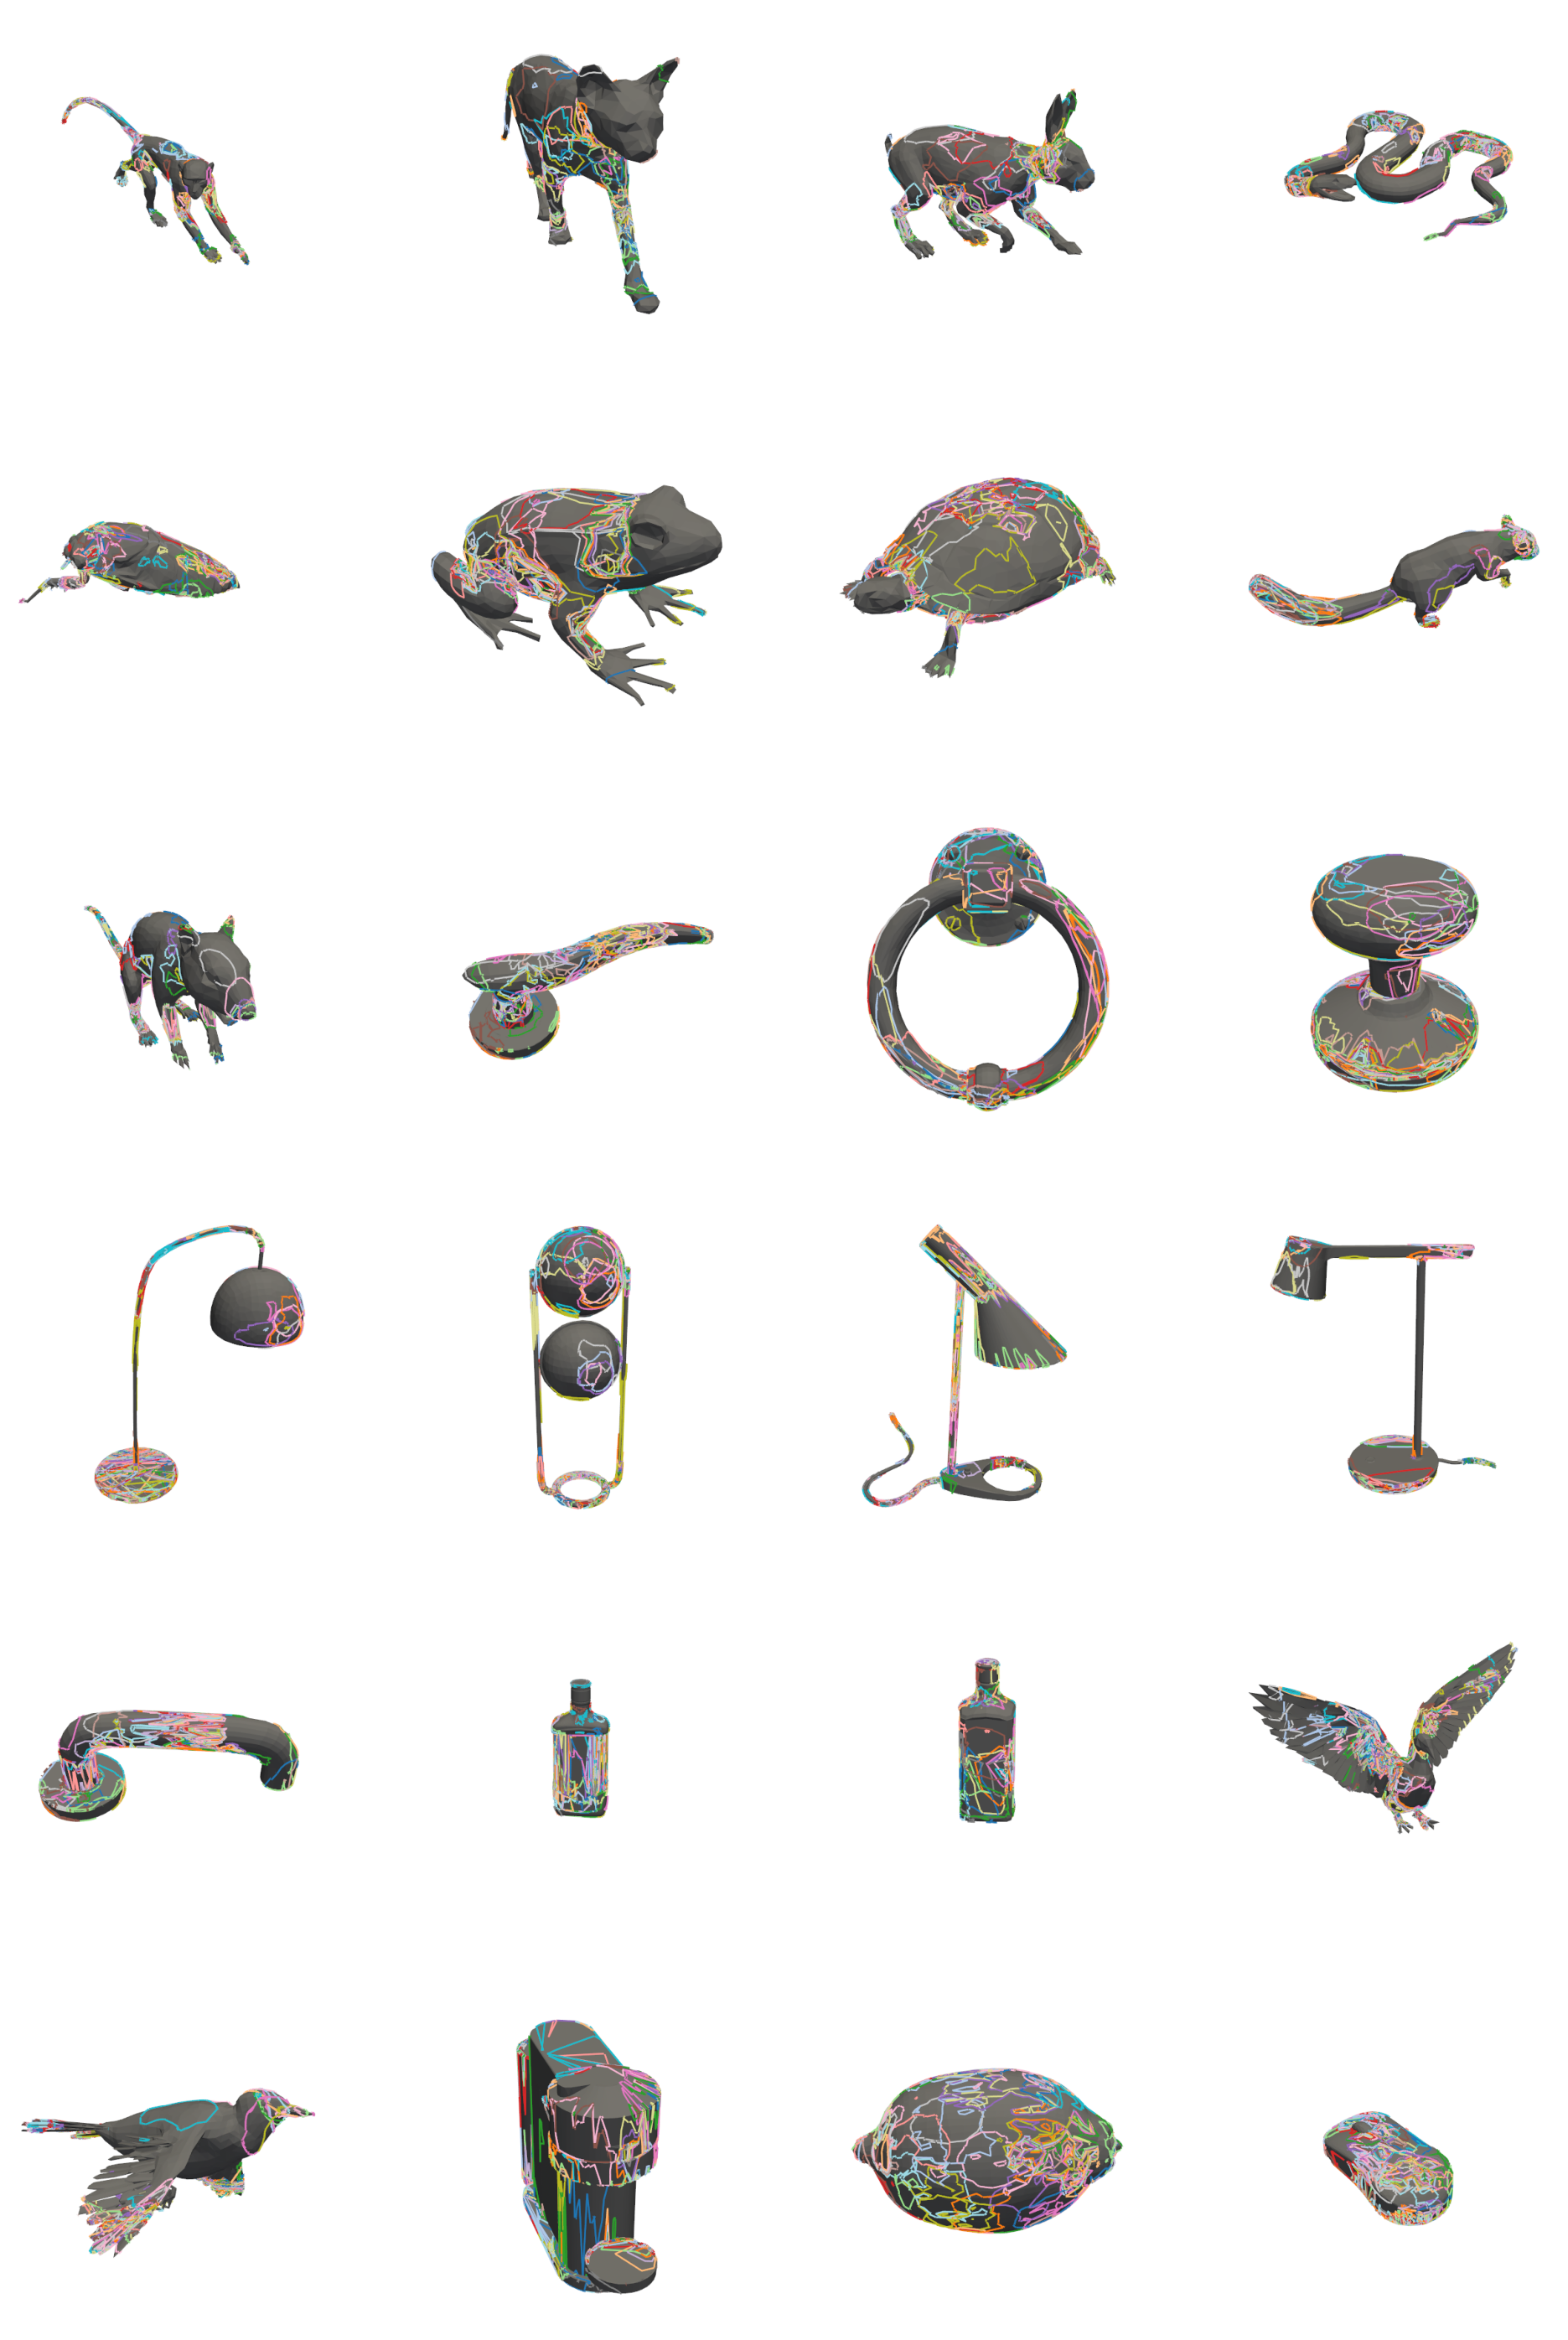

In [36]:
n_pms = len(pms)
grid_sz = nr, nc = (6, 4)
img_sz = 6
fig, axs = plt.subplots(nr, nc, figsize=(img_sz * nc, img_sz * nr))
pct = 98

for pm, vws, ax in zip(pms, cp_vertex_weights, axs.flatten()):
    pmp = ProbeMeshPlotter(pm=pm)
    norm_vws, norm_vw_thresholds = norm_weights(vws, pct)
    pmp.add_contours(weights=norm_vws, thresholds=norm_vw_thresholds, colors=cycle(mpl.colormaps['tab20'].colors))
    img = pmp.finish()
    ax.imshow(img)
    ax.axis('off')

fig.savefig('exported_channels/all_isocontours.png')